In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-rent-prediction-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2355600%2F4097760%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240727%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240727T062243Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dadbe952efa88378d0072e490372ba7451737831381dab600e6e9197990bb6e901a99601c41271d2b178929af2fedddedf637ce0e7d1aba03d0829820857132115f18a671056ce4e72968b104fdfb3ca3057d231340bee88a5ae5cbf5f8fe34b03dfebfcfa292c6d8b4479f6d98fb7e7347c12094a3485ff5e11037c68a6acba097fd0c3af34ac4bd074ef4f7e0d60d521719d04ca446a1c6f3a596d77b657b6b2cca1f6ed02be26a93a96dd119d918e13c757fbd27e0b48257340d8274bb1aaef832438451df92796697fd2fcead19dfd9bd99cad78cacd58282519987693cb22b4e5bde2f4dbcee6c6bdb6570f65e9887b84ea02534d7dfbcb231b896c766bc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 84399 bytes downloaded
Downloaded and uncompressed: house-rent-prediction-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv
/kaggle/input/house-rent-prediction-dataset/Dataset Glossary.txt


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


In [6]:
# Load dataset
df = pd.read_csv('/kaggle/input/house-rent-prediction-dataset/House_Rent_Dataset.csv')

# Display the first few rows of the dataset
print(df.head())

    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  2022-05-18    2  10000  1100  Ground out of 2   Super Area   
1  2022-05-13    2  20000   800       1 out of 3   Super Area   
2  2022-05-16    2  17000  1000       1 out of 3   Super Area   
3  2022-07-04    2  10000   800       1 out of 2   Super Area   
4  2022-05-09    2   7500   850       1 out of 2  Carpet Area   

              Area Locality     City Furnishing Status  Tenant Preferred  \
0                    Bandel  Kolkata       Unfurnished  Bachelors/Family   
1  Phool Bagan, Kankurgachi  Kolkata    Semi-Furnished  Bachelors/Family   
2   Salt Lake City Sector 2  Kolkata    Semi-Furnished  Bachelors/Family   
3               Dumdum Park  Kolkata       Unfurnished  Bachelors/Family   
4             South Dum Dum  Kolkata       Unfurnished         Bachelors   

   Bathroom Point of Contact  
0         2    Contact Owner  
1         1    Contact Owner  
2         1    Contact Owner  
3         1    Contact Owner

In [7]:
# Check for missing values
print(df.isnull().sum())

# EDA: Descriptive statistics
print(df.describe())

Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64
               BHK          Rent         Size     Bathroom
count  4746.000000  4.746000e+03  4746.000000  4746.000000
mean      2.083860  3.499345e+04   967.490729     1.965866
std       0.832256  7.810641e+04   634.202328     0.884532
min       1.000000  1.200000e+03    10.000000     1.000000
25%       2.000000  1.000000e+04   550.000000     1.000000
50%       2.000000  1.600000e+04   850.000000     2.000000
75%       3.000000  3.300000e+04  1200.000000     2.000000
max       6.000000  3.500000e+06  8000.000000    10.000000


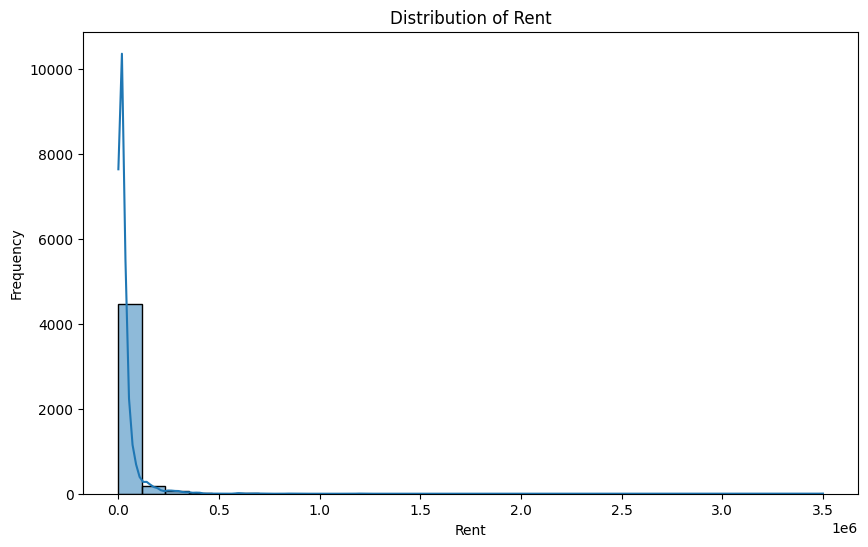

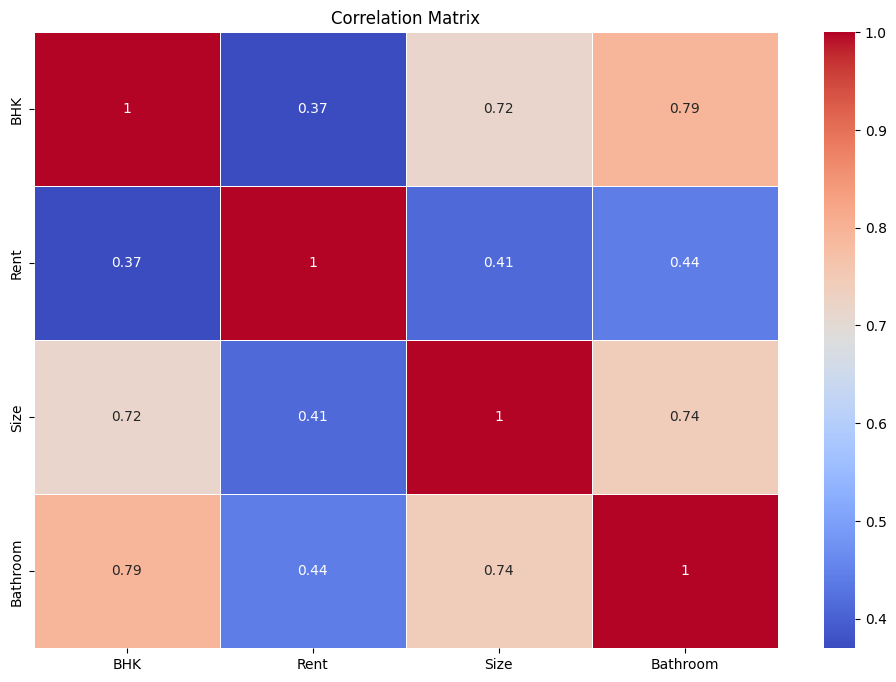

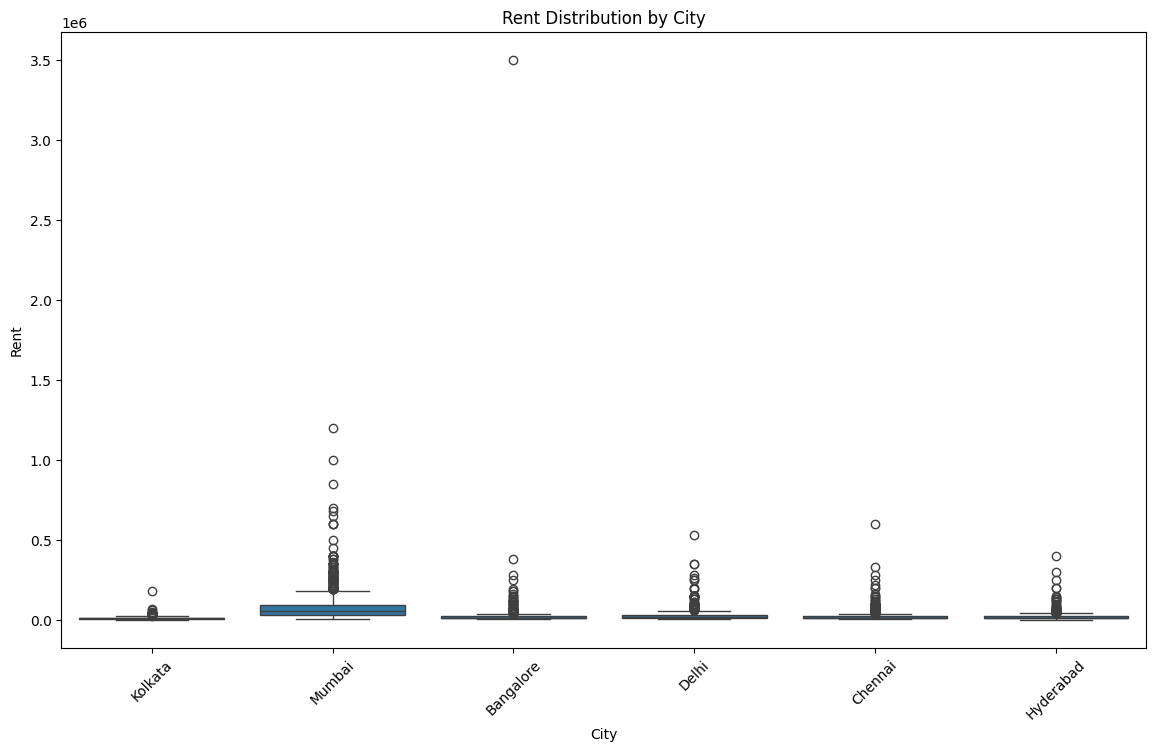

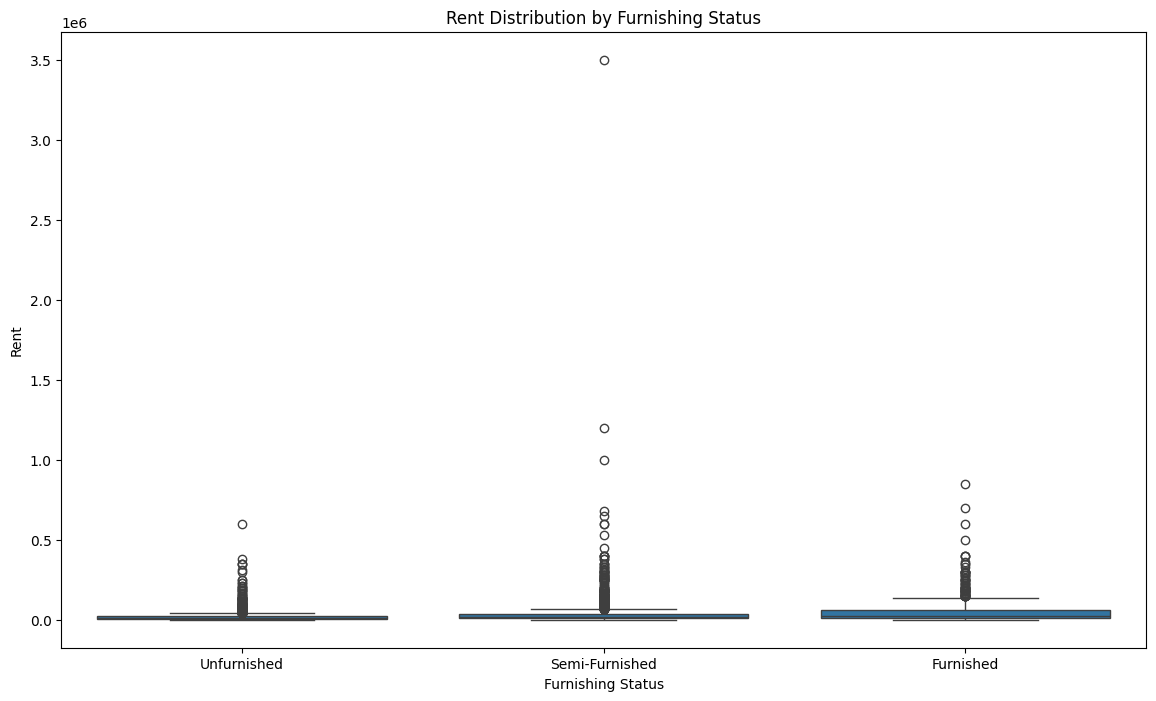

In [9]:
# EDA: Data distribution of the target variable 'Rent'
plt.figure(figsize=(10, 6))
sns.histplot(df['Rent'], bins=30, kde=True)
plt.title('Distribution of Rent')
plt.xlabel('Rent')
plt.ylabel('Frequency')
plt.show()

# EDA: Correlation matrix (excluding non-numeric columns)
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# EDA: Box plots of Rent with categorical variables
plt.figure(figsize=(14, 8))
sns.boxplot(x='City', y='Rent', data=df)
plt.title('Rent Distribution by City')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Furnishing Status', y='Rent', data=df)
plt.title('Rent Distribution by Furnishing Status')
plt.show()


In [14]:
# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Convert Rent to a classification problem by binarizing it
median_rent = df['Rent'].median()
df['Rent'] = (df['Rent'] > median_rent).astype(int)  # 1 if rent is above median, 0 otherwise

# Split dataset into features and target variable
X = df.drop('Rent', axis=1)
y = df['Rent']

In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.8736842105263158
Recall: 0.8189845474613686
F1 Score: 0.8607888631090486
Confusion Matrix:
[[459  38]
 [ 82 371]]


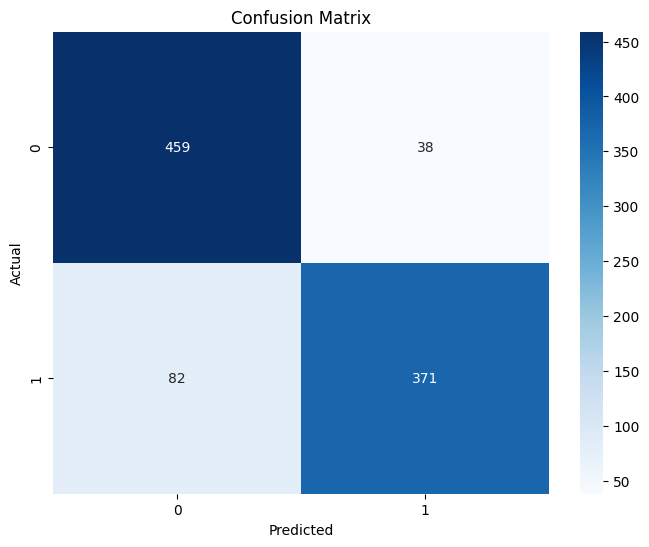

In [20]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

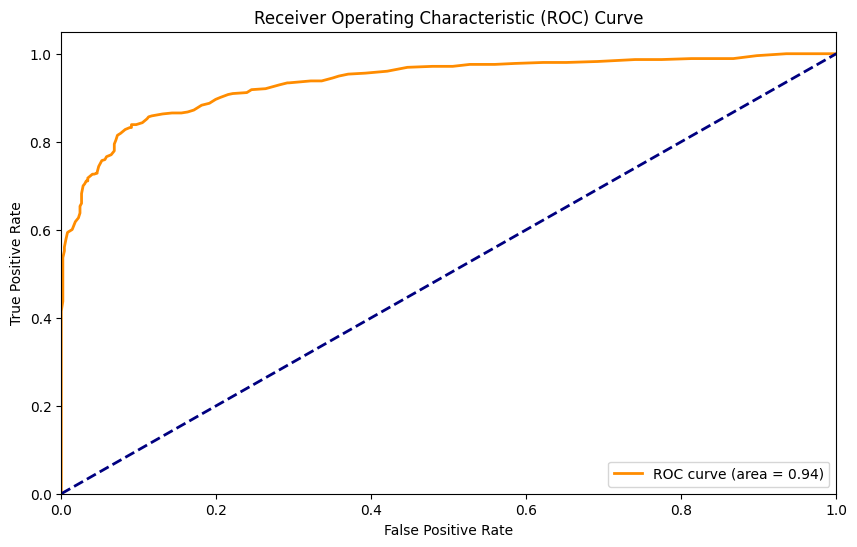

In [21]:
# Compute ROC curve and ROC area for each class
y_score = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()